In [1]:
import os
import json 
import time
import torch
import random
import datetime
import eda_utils
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict, Counter
from sklearn.model_selection import train_test_split
from sklearn.calibration import calibration_curve
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from torch.nn.functional import softmax
import torch.nn.functional as F
import torch.nn as nn 
from tqdm.auto import tqdm
from os.path import join
from IPython.display import Image
torch.manual_seed(42)
random.seed(42)

#### Load files

In [2]:
dt = datetime.datetime.fromtimestamp(time.time())
logdir = os.path.join('./outputs/' ,dt.strftime('%Y-%m-%d_%H:%M:%S'))

print(f'Logging to {logdir}')
if not os.path.exists(logdir):
    os.makedirs(logdir)

path_to_imagenet = '/scratch/users/saarimrahman/imagenet-testbed/outputs'
model_names = eda_utils.model_names
imagenet_dict = eda_utils.imagenet_dict
eval_settings = ['val', 'imagenetv2-matched-frequency']

ensembled_models = [
    'top5_ensemble', 'random5_ensemble', 'top5_random5_ensemble', 
    'class_weighted_top5_ensemble', 'class_weighted_random5_ensemble', 'class_weighted_top5_random5_ensemble',
    'acc_weighted_top5_ensemble', 'acc_weighted_random5_ensemble', 'acc_weighted_top5_random5_ensemble'
]

top_models = [
    'efficientnet-l2-noisystudent', 'FixResNeXt101_32x48d_v2', 'FixResNeXt101_32x48d', 
    'instagram-resnext101_32x48d', 'efficientnet-b8-advprop-autoaug', 'BiT-M-R152x4-ILSVRC2012', 
    'efficientnet-b7-advprop-autoaug', 'instagram-resnext101_32x32d', 'BiT-M-R101x3-ILSVRC2012', 
    'efficientnet-b6-advprop-autoaug', 'efficientnet-b7-randaug', 'efficientnet-b7-autoaug',
    'efficientnet-b5-advprop-autoaug', 'resnext101_32x8d_swsl', 'instagram-resnext101_32x16d',
    'BiT-M-R50x3-ILSVRC2012', 'efficientnet-b6-autoaug', 'FixPNASNet',
    'efficientnet-b5-autoaug', 'efficientnet-b5-randaug', 'resnext101_32x4d_swsl'
]

top5_models = top_models[:5]
print('top5_models', top5_models)
# TODO: random 5 from the top 15-20
random5_models = ['FixPNASNet', 'dpn68', 'fbresnet152', 'pnasnet5large', 'vgg19']


Logging to ./outputs/2021-06-15_21:20:07
top5_models ['efficientnet-l2-noisystudent', 'FixResNeXt101_32x48d_v2', 'FixResNeXt101_32x48d', 'instagram-resnext101_32x48d', 'efficientnet-b8-advprop-autoaug']


In [3]:
def load_logits_targets(models_to_load):
    logits = defaultdict(dict)
    targets = {}
    output_folders = os.listdir(path_to_imagenet)
    for model in tqdm(models_to_load, desc='load_logits_targets', leave=False):
        for eval_setting in ['val', 'imagenetv2-matched-frequency']:
            output_folder = model + '-' + eval_setting
            if output_folder in output_folders:
                model_targets = os.path.join(path_to_imagenet, output_folder, 'targets.pt')
                model_logits = os.path.join(path_to_imagenet, output_folder, 'logits.pt')
                if os.path.exists(model_logits):
                    logits[eval_setting][model] = torch.load(model_logits)
                if eval_setting not in targets and os.path.exists(model_targets):
                    targets[eval_setting] = torch.load(model_targets)
    return logits, targets

def find_missing_logits(models, eval_setting='val'):
    print(f'Checking for missing {eval_setting} logits...')
    on_disk, missing = [], []
    output_folders = os.listdir(path_to_imagenet)
    for model in models:
        output_folder = model + '-' + eval_setting
        if output_folder in output_folders:
            model_logits = os.path.join(path_to_imagenet, output_folder, 'logits.pt')
            if os.path.exists(model_logits):
                on_disk.append(model)
            else:
                missing.append(model)
        else:
            missing.append(model)
    print(len(missing), 'models missing:', missing)
    return on_disk, missing


find_missing_logits(top5_models + random5_models, 'val')
find_missing_logits(top5_models + random5_models, 'imagenetv2-matched-frequency')

find_missing_logits(top_models[:5], 'val')
find_missing_logits(top_models[:5], 'imagenetv2-matched-frequency')

logits, targets = load_logits_targets(top5_models + random5_models)


Checking for missing val logits...
0 models missing: []
Checking for missing imagenetv2-matched-frequency logits...
0 models missing: []
Checking for missing val logits...
0 models missing: []
Checking for missing imagenetv2-matched-frequency logits...
0 models missing: []


load_logits_targets:   0%|          | 0/10 [00:00<?, ?it/s]

#### Helper Functions

In [4]:
def accuracy_topk(logits, targets, topk=1):
    batch_size = targets.size(0)

    _, pred = logits.topk(topk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(targets.view(1, -1).expand_as(pred))

    correct_k = correct[:topk].view(-1).float().sum(0, keepdim=True)
    return correct_k.mul_(100.0 / batch_size).item()

def find_correct(logits, targets, topk=1):
    """Returns a boolean tensor showing correct predictions"""
    batch_size = targets.size(0)

    _, pred = logits.topk(topk, 1, True, True)
    pred = pred.t()
    return pred.eq(targets.view(1, -1).expand_as(pred))

def get_pred(logits, topk=1):
    _, pred = logits.topk(topk, 1, True, True)
    return pred.t()
    
def num_pairwise_errors(x_correct, y_correct):
    """Finds the number of shared elements incorrectly classified for x and y"""
    
    assert x_correct.size() == y_correct.size(), 'x and y are not the same size'
    x_error_idx = (x_correct == False).nonzero(as_tuple=True)[1]
    y_error_idx = (y_correct == False).nonzero(as_tuple=True)[1]
    return len(np.intersect1d(x_error_idx, y_error_idx))

def pairwise_corrcoef(x_logits, y_logits):
    """Applies softmax to each row of 50000 entries, flattens, then calculates correlation
    Note: Logits are originally of shape torch.Size([50000, 1000])
    """
    sigmoid_x = torch.nn.functional.softmax(x_logits, dim=1).flatten().numpy()
    sigmoid_y = torch.nn.functional.softmax(y_logits, dim=1).flatten().numpy()
    return np.corrcoef(sigmoid_x, sigmoid_y)[0][1]

def partition(data, eval_setting='val'):
    return train_test_split(data, test_size=0.5, stratify=targets[eval_setting], random_state=42)
    
def view_image(index, eval_setting='val'):
    datasets_path = '/scratch/users/saarimrahman/imagenet-testbed/s3_cache/datasets'
    eval_data_path = join(datasets_path, eval_setting)
    num_img_per_class = targets[eval_setting].size(0) // 1000
    folder_idx = index // num_img_per_class 
    img_idx = index % num_img_per_class
    folder = sorted(os.listdir(eval_data_path))[folder_idx]
    folder_path = join(eval_data_path, folder)
    file_name = sorted(os.listdir(folder_path))[img_idx]
    img_path = join(folder_path, file_name)
    print('true class:', imagenet_dict[index // num_img_per_class])
    display(Image(filename=img_path))
    
def sort_dict(dic):
    return dict(sorted(dic.items(), key=lambda item: item[1], reverse=True))

#### Pairwise Error Overlap

In [5]:
def create_pairwise_error_df(eval_setting):
    pairwise_errors = defaultdict(dict)
    eval_targets = targets[eval_setting]

    for x_model, x_logits in tqdm(logits[eval_setting].items(), desc=eval_setting, leave=False):
        x_correct = find_correct(x_logits, eval_targets)
        x_correct_train, x_correct_test = partition(x_correct.flatten())
        x_correct_train = x_correct_train.view(1, -1)
        
        for y_model, y_logits in logits[eval_setting].items():
            y_correct = find_correct(y_logits, eval_targets)
            y_correct_train, y_correct_test = partition(y_correct.flatten())
            y_correct_train = y_correct_train.view(1, -1)

            # utilize symmetric property of pairwise matrix to reduce computation
            if x_model != y_model and y_model in pairwise_errors and x_model in pairwise_errors[y_model]:
                pairwise_errors[x_model][y_model] = pairwise_errors[y_model][x_model]
            else:
                pairwise_errors[x_model][y_model] = num_pairwise_errors(x_correct_train, y_correct_train)

    df = pd.DataFrame(pairwise_errors)
    styles = [dict(selector='caption', props=[('caption-side', 'top'), ("font-size", "150%")])]
    df = df.style.set_table_styles(styles).set_caption(eval_setting)
    return df.data

# df_val_pairwise_error = create_pairwise_error_df('val')

In [6]:
# sns.clustermap(df_val_pairwise_error)
# plt.title('Pairwise Error on val')
# plt.savefig(join(logdir, 'pairwise_error_val'))
# plt.show();

#### Pairwise Correlation Between Concatenated Predicted Probability Vectors

In [12]:
def create_pairwise_corr_df(eval_setting):
    pairwise_corr = defaultdict(dict)
    eval_targets = targets[eval_setting]

    for x_model, x_logits in tqdm(logits[eval_setting].items(), desc=eval_setting, leave=False):
        x_train, x_test = partition(x_logits)
        
        for y_model, y_logits in logits[eval_setting].items():
            y_train, y_test = partition(y_logits)
            
            # utilize symmetric property of pairwise matrix to reduce computation
            if x_model != y_model and y_model in pairwise_corr and x_model in pairwise_corr[y_model]:
                pairwise_corr[x_model][y_model] = pairwise_corr[y_model][x_model]
            else:
                pairwise_corr[x_model][y_model] = pairwise_corrcoef(x_train, y_train)

    df = pd.DataFrame(pairwise_corr)
    styles = [dict(selector='caption', props=[('caption-side', 'top'), ("font-size", "150%")])]
    df = df.style.set_table_styles(styles).set_caption(eval_setting)
    return df.data

# df_val_pairwise_corr = create_pairwise_corr_df('val')

In [13]:
# sns.clustermap(df_val_pairwise_corr);
# plt.title('Pairwise Correlation on val')
# plt.savefig(join(logdir, 'pairwise_corr_val'))
# plt.show();

#### Ensembling Ideas

In [14]:
def get_ensemble_logits(softmax_pred):
    """Construct ensemble logits from a tensor containing all ensemble model's softmax predictions."""
    ensemble_logits = []
    for i in range(softmax_pred.size(1)): # 50000 examples
        logit = torch.mean(softmax_pred[:, i, :], 0)
        ensemble_logits.append(logit)
    
    return torch.stack(ensemble_logits)

def ensemble_models(models, eval_setting='val'):
    softmax_pred, pred = [], []
    
    for model in models:
        softmax_pred.append(softmax(logits[eval_setting][model], dim=1))
    softmax_pred = torch.stack(softmax_pred)
    
    return get_ensemble_logits(softmax_pred)

def majority_vote_models(models):
    pred = get_pred(logits['val'][models[0]])
    for model in models[1:]:
        pred = torch.cat((pred, get_pred(logits['val'][model])), 0)
    return torch.mode(pred, 0, keepdim=True)[0]

for eval_setting in ['val', 'imagenetv2-matched-frequency']:
    logits[eval_setting]['top5_ensemble'] = ensemble_models(top5_models, eval_setting)
    logits[eval_setting]['random5_ensemble'] = ensemble_models(random5_models, eval_setting)
    logits[eval_setting]['top5_random5_ensemble'] = ensemble_models(top5_models + random5_models, eval_setting)

In [15]:
def class_weighted_ensemble(models, eval_setting='val'):
    """Weights each model's softmax predictions based on its relative accuracy in the class.
    Uses half of the class images to calculate in class accuracy. 
    """
    w = [] 
    for model in models:
        class_acc = []
        pred = get_pred(logits[eval_setting][model])
        miss = pred.eq(targets[eval_setting].view(1, -1).expand_as(pred)).float().flatten()
        total_images = targets[eval_setting].size(0)
        step_size = total_images // 1000
        i = 0
        while i < total_images:
            class_acc.append(miss[i:i+(step_size // 2)].sum().item() / (step_size // 2)) # calculate relative in class accuracy
            i += step_size
        w.append(torch.tensor(class_acc))
    
    w = torch.stack(w)
#     np.savetxt(models[0], w.numpy())
    weighted_softmax_pred = []
    for i, model in enumerate(models):
        probs = softmax(logits[eval_setting][model], dim=1)
        weighted_pred = torch.mul(probs, w[i])
        weighted_softmax_pred.append(weighted_pred) 
    
    weighted_softmax_pred = torch.stack(weighted_softmax_pred)
    return get_ensemble_logits(weighted_softmax_pred)

for eval_setting in ['val', 'imagenetv2-matched-frequency']:
    logits[eval_setting]['class_weighted_top5_ensemble'] = class_weighted_ensemble(top5_models, eval_setting)
    logits[eval_setting]['class_weighted_random5_ensemble'] = class_weighted_ensemble(random5_models, eval_setting)
    logits[eval_setting]['class_weighted_top5_random5_ensemble'] = class_weighted_ensemble(top5_models + random5_models, eval_setting)

# class_weighted_ensemble(['vgg19'], 'val')
# class_weighted_ensemble(['efficientnet-l2-noisystudent'], 'val')

In [16]:
def acc_weighted_ensemble(models, eval_setting='val'):
    """Weights each model's softmax predictions based on its overall accuracy on the dataset.
    Uses half of the dataset to calculate overall accuracy.
    """
    eval_targets_train, eval_targets_test = partition(targets[eval_setting], eval_setting)

    weighted_softmax_pred = []
    for model in models:
        train_logit, _ = partition(logits[eval_setting][model], eval_setting)
        acc = accuracy_topk(train_logit, eval_targets_train)
        probs = softmax(logits[eval_setting][model], dim=1)
        weighted_pred = torch.mul(probs, acc)
        weighted_softmax_pred.append(weighted_pred) 
        
    weighted_softmax_pred = torch.stack(weighted_softmax_pred)
    return get_ensemble_logits(weighted_softmax_pred)

for eval_setting in ['val', 'imagenetv2-matched-frequency']:
    logits[eval_setting]['acc_weighted_top5_ensemble'] = acc_weighted_ensemble(top5_models, eval_setting)
    logits[eval_setting]['acc_weighted_random5_ensemble'] = acc_weighted_ensemble(random5_models, eval_setting)
    logits[eval_setting]['acc_weighted_top5_random5_ensemble'] = acc_weighted_ensemble(top5_models + random5_models, eval_setting)

## Which examples do all the models miss?

In [ ]:
def get_miss_freq(eval_setting, topk, model_pred):
    eval_targets_train, eval_targets_test = partition(targets[eval_setting], eval_setting)
    train_indices, test_indices = partition(np.arange(0, targets[eval_setting].size(0)), eval_setting)
    
    miss = [] # boolean tensor of correctness of model predictions for each model
    for x_model, x_logits in logits[eval_setting].items():
        pred = get_pred(logits[eval_setting][x_model], topk) # top k prediction
        tmp = []
        for i in range(pred.size(0)):
            tmp.append(partition(pred[i], eval_setting)[0]) # training pred
        pred = torch.stack(tmp)
        model_pred[eval_setting][x_model] = pred

        correct = pred.eq(eval_targets_train.view(1, -1).expand_as(pred))
        corr = []
        for i in range(correct.size(1)):
            if correct[:,i].sum() > 0:
                corr.append(True)
            else:
                corr.append(False)
        miss.append(corr)
    miss = torch.tensor(miss)
    
    shared_miss = [] # identify examples that all models miss. has original indices
    shared_miss_train = [] # has training indices
    no_miss = [] # identify examples that no models miss. has original indices.
    no_miss_train = [] # has training indices
    
    for i in range(miss.size(1)): # iterate over every image 
        if torch.sum(miss[:, i]) == 0: # every model incorectly classified the image
            shared_miss_train.append(i)
            shared_miss.append(train_indices[i]) # map from shuffled index -> original index
        elif torch.sum(miss[:, i]) == miss.size(0): # every model correctly classified the image
            no_miss_train.append(i)
            no_miss.append(train_indices[i])

    print(f'total # examples that all models miss (top-{topk}; {eval_setting}):', len(shared_miss), '/', len(eval_targets_train))

    miss_freq = defaultdict(int)
    for i in shared_miss:
        true_class = targets[eval_setting][i]
        miss_freq[int(true_class)] += 1

    no_miss_freq = defaultdict(int)
    for i in no_miss:
        true_class = targets[eval_setting][i]
        no_miss_freq[int(true_class)] += 1

    miss_freq = sort_dict(miss_freq)
    no_miss_freq = sort_dict(no_miss_freq)
    
    return miss_freq, no_miss_freq, shared_miss, shared_miss_train, no_miss, no_miss_train

def visualize_errors(classes, miss_dict, miss_dict_train, model_pred, eval_setting='val'):
    if len(classes) == 0:
        print('no classes to display')
        return
    classes_seen = []
    for ctr, i in enumerate(miss_dict):
        image_class = targets[eval_setting][i].item()
        
        if image_class in classes and image_class not in classes_seen:
            models_predicted = []
            n = len(list(model_pred[eval_setting].values())[0])
            for j in range(n):
                models_predicted = [imagenet_dict[pred[j][miss_dict_train[ctr]].item()] for model, pred in model_pred[eval_setting].items()]
                models_predicted = Counter(models_predicted)
                print(f'top-{j+1} predictions:', models_predicted)
            view_image(i, eval_setting)
            classes_seen.append(image_class)

#### Imagenet V1

#### Top-1 Errors

In [ ]:
model_pred = defaultdict(dict) # contains training top-1 model preds
miss_freq, no_miss_freq, shared_miss, shared_miss_train, no_miss, no_miss_train = get_miss_freq('val', 1, model_pred)

In [ ]:
plt.hist(list(miss_freq.values()), bins=20)
plt.title('Distribution of # misclassified examples (top-1; val)')
plt.xlabel('# misclassified')
plt.ylabel('# classes')
plt.savefig(join(logdir, 'val_top1_classes_misclassified_dist'))
plt.show();

In [ ]:
n = 20 # number of classes to display
plt.bar([imagenet_dict[i] for i in miss_freq.keys()][:n], list(miss_freq.values())[:n])
plt.xticks(rotation = 90)
plt.title(f'Top {n} classes missclassified by all models (top-1; val)')
plt.ylabel('# misclassifications')
plt.savefig(join(logdir, 'val_top1_top_classes_misclassified'))
plt.show();

In [ ]:
top_worst_classes = list(miss_freq.keys())[:5]
visualize_errors(top_worst_classes, shared_miss, shared_miss_train, model_pred, 'val')

In [ ]:
best_classes = list(no_miss_freq.keys())[-5:]
visualize_errors(best_classes, no_miss, no_miss_train, model_pred, 'val')

In [ ]:
np.random.seed(42)
random_classes = np.random.permutation(list(miss_freq.keys()))[:10]
visualize_errors(random_classes, shared_miss, shared_miss_train, model_pred, 'val')

#### Top-3 Errors

In [ ]:
top3_model_pred = defaultdict(dict) # contains training top-3 model pred
top3_miss_freq, top3_no_miss_freq, top3_shared_miss, top3_shared_miss_train, top3_no_miss, top3_no_miss_train = get_miss_freq('val', 3, top3_model_pred)

In [ ]:
plt.hist(list(top3_miss_freq.values()), bins=20)
plt.title('Distribution of # misclassified examples (top-3; val)')
plt.xlabel('# misclassified')
plt.ylabel('# classes')
plt.savefig(join(logdir, 'val_top3_classes_misclassified_dist'))
plt.show();

In [ ]:
n = 20 # number of classes to display
plt.bar([imagenet_dict[i] for i in top3_miss_freq.keys()][:n], list(top3_miss_freq.values())[:n])
plt.xticks(rotation = 90)
plt.title(f'Top {n} classes missclassified by all models (top-3; val)')
plt.ylabel('# misclassifications')
plt.savefig(join(logdir, 'val_top3_top_classes_misclassified'))
plt.show();

In [ ]:
top_worst_classes = list(top3_miss_freq.keys())[:5]
visualize_errors(top_worst_classes, top3_shared_miss, top3_shared_miss_train, top3_model_pred)

In [ ]:
best_classes = list(top3_no_miss_freq.keys())[-5:]
visualize_errors(best_classes, top3_no_miss, top3_no_miss_train, top3_model_pred)

In [ ]:
np.random.seed(42)
random_classes = np.random.permutation(list(top3_miss_freq.keys()))[:10]
visualize_errors(random_classes, top3_shared_miss, top3_shared_miss_train, top3_model_pred)

#### Imagenet V2

#### Top-1 Errors

In [ ]:
miss_freq, no_miss_freq, shared_miss, shared_miss_train, no_miss, no_miss_train = get_miss_freq('imagenetv2-matched-frequency', 1, model_pred)

In [ ]:
plt.hist(list(miss_freq.values()), bins=20)
plt.title('Distribution of # misclassified examples (top-1; imagenetv2)')
plt.xlabel('# misclassified')
plt.ylabel('# classes')
plt.savefig(join(logdir, 'imagenetv2_top1_classes_misclassified_dist'))
plt.show();

In [ ]:
n = 20 # number of classes to display
plt.bar([imagenet_dict[i] for i in miss_freq.keys()][:n], list(miss_freq.values())[:n])
plt.xticks(rotation = 90)
plt.title(f'Top {n} classes missclassified by all models (top-1; imagenetv2)')
plt.ylabel('# misclassifications')
plt.savefig(join(logdir, 'imagenetv2_top1_top_classes_misclassified'))
plt.show();

In [ ]:
top_worst_classes = list(miss_freq.keys())[:5]
visualize_errors(top_worst_classes, shared_miss, shared_miss_train, model_pred, 'imagenetv2-matched-frequency')

In [ ]:
best_classes = list(no_miss_freq.keys())[-5:]
visualize_errors(best_classes, no_miss, no_miss_train, model_pred, 'imagenetv2-matched-frequency')

In [ ]:
np.random.seed(42)
random_classes = np.random.permutation(list(miss_freq.keys()))[:10]
visualize_errors(random_classes, shared_miss, shared_miss_train, model_pred, 'imagenetv2-matched-frequency')

#### Top-3 Errors

In [ ]:
top3_miss_freq, top3_no_miss_freq, top3_shared_miss, top3_shared_miss_train, top3_no_miss, top3_no_miss_train = get_miss_freq('imagenetv2-matched-frequency', 3, top3_model_pred)

In [ ]:
plt.hist(list(top3_miss_freq.values()), bins=5)
plt.title('Distribution of # misclassified examples (top-3; imagenetv2)')
plt.xlabel('# misclassified')
plt.ylabel('# classes')
plt.savefig(join(logdir, 'imagenetv2_top3_classes_misclassified_dist'))
plt.show();

In [ ]:
n = 20 # number of classes to display
plt.bar([imagenet_dict[i] for i in top3_miss_freq.keys()][:n], list(top3_miss_freq.values())[:n])
plt.xticks(rotation = 90)
plt.title(f'Top {n} classes missclassified by all models (top-3; imagenetv2)')
plt.ylabel('# misclassifications')
plt.savefig(join(logdir, 'imagenetv2_top3_top_classes_misclassified'))
plt.show();

In [ ]:
# TODO: fix no output from below
top_worst_classes = list(top3_miss_freq.keys())[:5]
visualize_errors(top_worst_classes, top3_shared_miss, top3_shared_miss_train, top3_model_pred)

In [ ]:
best_classes = list(top3_no_miss_freq.keys())[-5:]
visualize_errors(best_classes, top3_no_miss, top3_no_miss_train, top3_model_pred)

In [ ]:
np.random.seed(42)
random_classes = np.random.permutation(list(top3_miss_freq.keys()))[:10]
visualize_errors(random_classes, top3_shared_miss, top3_shared_miss_train, top3_model_pred)

## Cross Class Accuracies

In [ ]:
def plot_cross_class_acc(eval_setting='val'):
    eval_targets_train, eval_targets_test = partition(targets[eval_setting], eval_setting)

    class_acc = {}
    for model, pred in model_pred[eval_setting].items():
        acc = {}
        for i in np.arange(0, 1000):
            mask = (eval_targets_train == i).expand_as(model_pred[eval_setting][model])
            corr_class_pred = model_pred[eval_setting][model][mask] == i
            acc[i] = int(torch.sum(corr_class_pred)) / len(corr_class_pred)
        class_acc[model] = acc
        
    fig, axs = plt.subplots(5, 4, figsize=(25,25), facecolor='w', edgecolor='k', sharey=True)
    axs = axs.ravel()

    i = 0
    y_model = 'efficientnet-l2-noisystudent'
    for model, acc in class_acc.items():
        if model == y_model:
            continue
        axs[i].set_title(f'cross class accuracy \n ({eval_setting}; top-1)')
        x_model_acc = list(acc.values())
        y_model_acc = list(class_acc[y_model].values())
        
        if eval_setting == eval_settings[1]:
            x_model_acc += np.random.normal(0, 0.01, len(x_model_acc))
            y_model_acc += np.random.normal(0, 0.01, len(x_model_acc))
            
        axs[i].scatter(x_model_acc, y_model_acc, s=10, alpha=0.2)
        axs[i].plot([0, 1], [0, 1], '--', color='orange')
        axs[i].set_xlabel(model)
        axs[i].set_ylabel(y_model)
        i += 1
    plt.tight_layout()
    plt.savefig(join(logdir, f'{eval_setting}_cross_class_accuracy'))

In [ ]:
# plot_cross_class_acc('val')

In [ ]:
plot_cross_class_acc('imagenetv2-matched-frequency')

In [ ]:
def plot_v1v2_cross_class_acc(model):
    eval_setting = eval_settings[0]
    eval_targets_train, eval_targets_test = partition(targets[eval_setting], eval_setting)

    v1_class_acc = {}
    pred = model_pred[eval_setting]
    for i in np.arange(0, 1000):
        mask = (eval_targets_train == i).expand_as(model_pred[eval_setting][model])
        corr_class_pred = model_pred[eval_setting][model][mask] == i
        v1_class_acc[i] = int(torch.sum(corr_class_pred)) / len(corr_class_pred)

    
    eval_setting = eval_settings[1]
    eval_targets_train, eval_targets_test = partition(targets[eval_setting], eval_setting)
    
    v2_class_acc = {}
    pred = model_pred[eval_setting]
    for i in np.arange(0, 1000):
        mask = (eval_targets_train == i).expand_as(model_pred[eval_setting][model])
        corr_class_pred = model_pred[eval_setting][model][mask] == i
        v2_class_acc[i] = int(torch.sum(corr_class_pred)) / len(corr_class_pred) + np.random.normal(0, 0.01)
                
    plt.scatter(list(v1_class_acc.values()), list(v2_class_acc.values()), alpha=0.2)
    plt.plot([0, 1], [0, 1], '--', color='orange')
    plt.title(f'{model} cross class accuracy (top-1)')
    plt.xlabel('v1 class accuracy')
    plt.ylabel('v2 class accuracy')
    plt.show()

In [ ]:
models = ['efficientnet-l2-noisystudent', 'top5_ensemble']
for model in models:
    plot_v1v2_cross_class_acc(model)

## Test Accuracies

In [104]:
def plot_topk_model_acc(topk, eval_setting='val', verbose=False):
    model_acc = {}
    for model, logit in logits[eval_setting].items():
        eval_targets_train, eval_targets_test = partition(targets[eval_setting], eval_setting)
        train_logit, test_logit = partition(logit, eval_setting)
        acc = accuracy_topk(train_logit, eval_targets_train, topk)
        model_acc[model] = acc

    model_acc = sort_dict(model_acc)
    if verbose:
        display(model_acc)
    plt.xticks(rotation = 90)
    plt.title(f'Model Accuracies (top-{topk}; {eval_setting})')
    plt.ylabel('accuracy')
    plt.scatter(model_acc.keys(), model_acc.values())
    plt.savefig(join(logdir, f'model_acc_{eval_setting}_top{topk}'))
    plt.show();

In [105]:
eval_setting = eval_settings[1]
logit = logits[eval_setting]['class_weighted_top5_ensemble']
eval_targets_train, eval_targets_test = partition(targets[eval_setting], eval_setting)
train_logit, test_logit = partition(logit, eval_setting)
acc = accuracy_topk(train_logit, eval_targets_train, 1)

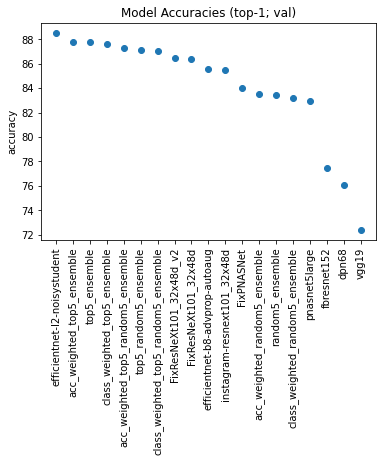

In [106]:
plot_topk_model_acc(1, 'val')

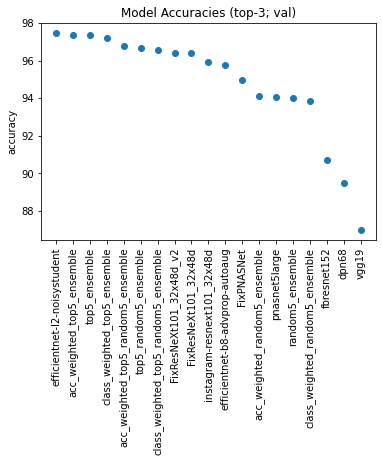

In [107]:
plot_topk_model_acc(3, 'val')

{'efficientnet-l2-noisystudent': 79.86000061035156,
 'top5_ensemble': 79.5,
 'acc_weighted_top5_ensemble': 79.5,
 'class_weighted_top5_ensemble': 79.0199966430664,
 'acc_weighted_top5_random5_ensemble': 78.5,
 'class_weighted_top5_random5_ensemble': 78.0999984741211,
 'top5_random5_ensemble': 78.05999755859375,
 'FixResNeXt101_32x48d_v2': 77.63999938964844,
 'FixResNeXt101_32x48d': 77.15999603271484,
 'instagram-resnext101_32x48d': 76.79999542236328,
 'efficientnet-b8-advprop-autoaug': 75.75999450683594,
 'FixPNASNet': 72.54000091552734,
 'acc_weighted_random5_ensemble': 72.18000030517578,
 'random5_ensemble': 72.0999984741211,
 'class_weighted_random5_ensemble': 71.97999572753906,
 'pnasnet5large': 71.83999633789062,
 'fbresnet152': 65.63999938964844,
 'dpn68': 62.52000045776367,
 'vgg19': 59.87999725341797}

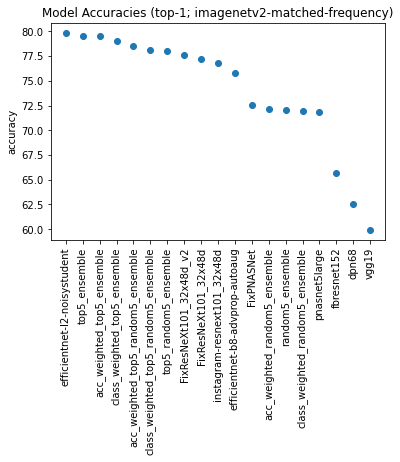

In [99]:
plot_topk_model_acc(1, 'imagenetv2-matched-frequency', verbose=True)

{'efficientnet-l2-noisystudent': 93.0999984741211,
 'acc_weighted_top5_ensemble': 93.0999984741211,
 'top5_ensemble': 93.05999755859375,
 'class_weighted_top5_ensemble': 92.33999633789062,
 'acc_weighted_top5_random5_ensemble': 91.87999725341797,
 'top5_random5_ensemble': 91.65999603271484,
 'class_weighted_top5_random5_ensemble': 91.15999603271484,
 'FixResNeXt101_32x48d_v2': 91.07999420166016,
 'FixResNeXt101_32x48d': 91.07999420166016,
 'instagram-resnext101_32x48d': 90.73999786376953,
 'efficientnet-b8-advprop-autoaug': 89.6199951171875,
 'FixPNASNet': 87.1199951171875,
 'pnasnet5large': 86.23999786376953,
 'acc_weighted_random5_ensemble': 86.23999786376953,
 'random5_ensemble': 86.04000091552734,
 'class_weighted_random5_ensemble': 85.0,
 'fbresnet152': 81.5,
 'dpn68': 79.87999725341797,
 'vgg19': 76.0}

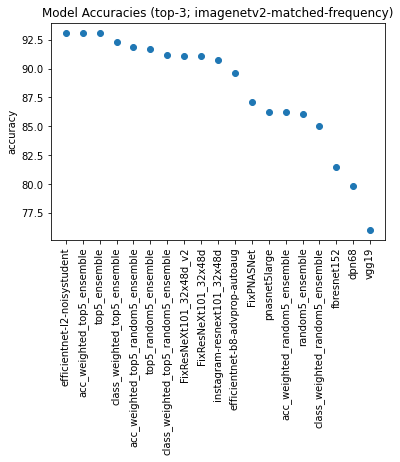

In [100]:
plot_topk_model_acc(3, 'imagenetv2-matched-frequency', verbose=True)

In [ ]:
def plot_ensemble_acc(models, topk, title):
    num_ensembled = np.arange(1, len(models))
    ensemble_acc = {}

    for i in tqdm(range(1, len(models)), leave=False, desc='ensemble'):
        logit = ensemble_models(models[:i])
        train_logit, test_logit = partition(logit)
        acc = accuracy_topk(train_logit, eval_targets_train, topk)
        ensemble_acc[i] = acc
    
    plt.plot(list(ensemble_acc.keys()), list(ensemble_acc.values()));
    plt.xlabel('Number of models ensembled')
    plt.ylabel('Accuracy')
    plt.title(f'{title} Ensemble Accuracies (top-{topk})')
    plt.savefig(join(logdir, f'{title}_ensemble_acc_top{topk}'))
    plt.show();
    
    return ensemble_acc

In [ ]:
# logits, targets = load_logits_targets(top_models)
# models_on_disk, _ = find_missing_logits(top_models)
# top_model_ens_acc_top1 = plot_ensemble_acc(models_on_disk, 1, 'top_models')
# top_model_ens_acc_top3 = plot_ensemble_acc(models_on_disk, 3, 'top_models')

In [ ]:
# np.random.seed(42)
# random_models = np.random.permutation(model_names)[:10]
# logits, targets = load_logits_targets(random_models)
# models_on_disk, _ = find_missing_logits(random_models)
# rand_model_ens_acc_top1 = plot_ensemble_acc(models_on_disk, 1, 'random_models')
# rand_model_ens_acc_top3 = plot_ensemble_acc(models_on_disk, 3, 'random_models')

## Calibration Curve

In [ ]:
def plot_calibration_curve(model, eval_setting='val', topk=1):
    """Method #2 that Raaz described.
    Checks the calibrtion of the max softmax scores normalized. 
    y_pred is the max softmax score for a given image
    y_true is if the image was correctly classified or not
    """
    eval_targets_train, eval_targets_test = partition(targets[eval_setting], eval_setting)
    x = logits[eval_setting][model]
    if 'ensemble' not in model: # ensembled logits have already been through softmax
        x = softmax(x, dim=1)
    x[x != x] = 0 # set nan values to zero.
    x = x / torch.sum(x, 1)[:, None] # normalize each image to total probability of 1

    prob, pred = x.topk(topk, 1, True, True)
    pred = pred.t()
    
    train_pred = []
    for i in range(pred.size(0)):
        train_pred.append(partition(pred[i], eval_setting)[0]) # training pred
    pred = torch.stack(train_pred)
    prob = prob.sum(1) # sum normalized topk probabilities
    correct = pred.eq(eval_targets_train.view(1, -1).expand_as(pred))
    
    corr = []
    for i in range(correct.size(1)):
        if correct[:,i].sum() > 0: # one of topk classified correctly
            corr.append(True)
        else:
            corr.append(False)
            
    y_true = torch.tensor(corr).float()
    y_prob = prob.flatten()
    y_prob, _ = partition(y_prob, eval_setting)
    
    normalize = False
    if y_prob.min() < 0 or y_prob.max() > 1: # scikit learn complains if probability is exactly 0 or 1
        normalize = True
    fraction_of_positives, mean_predicted_value  = calibration_curve(y_true, y_prob, n_bins=30, strategy='quantile', normalize=normalize)
    
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs.ravel()
    
    axs[0].set_title('Predicted Probability Distribution')
    axs[0].hist(y_prob, density=True, bins=30, alpha=0.5)
    axs[0].set_xlabel('probability')
    axs[0].set_ylabel('# of elements')
    
    axs[1].plot(mean_predicted_value, fraction_of_positives, linestyle='None', marker='D')
    axs[1].set_ylabel('Fraction of positives')
    axs[1].set_xlabel('Mean predicted value')
    axs[1].plot([0, 1], [0, 1], '--')
    axs[1].set_title(f'Calibration Curve for {model} \n (top-{topk}; {eval_setting})')
    
    cutoff = 0.9 # predicted probability cutoff 
    zoom_idxs = np.argwhere(mean_predicted_value > cutoff).flatten()
    zoom_mpv = mean_predicted_value[zoom_idxs]
    zoom_fop = fraction_of_positives[zoom_idxs]
    min_ax = min(min(zoom_mpv), min(zoom_fop)) # min value to start plot of y=x to get a square graph
    
    axs[2].plot(zoom_mpv, zoom_fop, linestyle='None', marker='D')
    axs[2].plot([min_ax, 1], [min_ax, 1], '--', color='orange')
    axs[2].set_ylabel('Fraction of positives')
    axs[2].set_xlabel('Mean predicted value')
    axs[2].set_title('Zoomed in Calibration Curve')
    
    plt.savefig(join(logdir, f'calibration_{model}_{eval_setting}_top{topk}'))
    plt.show();

In [ ]:
for eval_setting in eval_settings:
    for model in ensembled_models + top5_models + random5_models:
        for topk in [1, 3]:
            plot_calibration_curve(model, eval_setting, topk)
    print(f'***** Done with {eval_setting} *****')

In [ ]:
def plot_class_calibration_curve(model, img_class):
    """Method #3 that Raaz described.
    y_pred is the normalized softmax score for a given class
    y_true is if the image's label was that class or not
    """
    x = logits['val'][model]
    if 'ensemble' not in model: # ensembled logits have already been through softmax
        x = softmax(x, dim=1)
    x = x / torch.sum(x, 1)[:, None] # normalize each image to total probability of 1
    x = x[:, img_class]
    y_true = (targets['val'] == img_class).float()
    y_true, _ = partition(y_true)
    y_prob, _ = partition(x)
    prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=25)
    plt.plot(prob_true, prob_pred)
    plt.plot([0, 1], [0, 1], '--')
    plt.title(f'Calibration Curve: {model} // {imagenet_dict[img_class]}')
    plt.savefig(join(logdir, f'class_calibration_{model}_{img_class}'))
    plt.show();

In [ ]:
# model = 'top5_ensemble'
# print('*'*15 + ' WORST CLASSES ' + 15* '*')
# for img_class in top_worst_classes:
#     plot_class_calibration_curve(model, img_class)

# print('*'*15 + ' BEST CLASSES ' + 15* '*')
# for img_class in best_classes:
#     plot_class_calibration_curve(model, img_class)

# print('*'*15 + ' RANDOM CLASSES ' + 15* '*')
# for img_class in random_classes:
#     plot_class_calibration_curve(model, img_class)

## Ensembling Analysis

### Cross Entropy Loss

In [118]:
def cross_entropy_loss(Y, Y_hat):
    Y = Y.cpu().detach().numpy()
    Y_hat = Y_hat.cpu().detach().numpy()
    
    Y_hat += 1e-15
    m = len(Y)
    return -1/m * np.sum(Y * np.log(Y_hat))

def plot_cross_entropy_loss(eval_setting, verbose=True):
    Y = F.one_hot(targets[eval_setting], num_classes=1000)
    Y, _ = partition(Y, eval_setting) # training Y
    loss = {}
    for model, logit in logits[eval_setting].items():
        Y_hat, _ = partition(logit, eval_setting) # training Y_hat
        if 'ensemble' not in model: # ensembled logits have already been through softmax
            Y_hat = softmax(Y_hat, dim=1)
        loss[model] = cross_entropy_loss(Y, Y_hat)
        
    loss = sort_dict(loss)
    if verbose:
        display(loss)
    plt.xticks(rotation = 90)
    plt.title(f'Cross Entropy Loss- {eval_setting}')
    plt.ylabel('loss')
    plt.scatter(loss.keys(), loss.values())
    plt.savefig(join(logdir, f'cross_entropy_loss_{eval_setting}'))
    plt.show();

{'vgg19': 1.1151058547123616,
 'dpn68': 0.9582911786311608,
 'class_weighted_random5_ensemble': 0.950636600681171,
 'fbresnet152': 0.9018069743528501,
 'pnasnet5large': 0.8080857961033432,
 'class_weighted_top5_random5_ensemble': 0.7290349671708793,
 'random5_ensemble': 0.6901824604170723,
 'efficientnet-b8-advprop-autoaug': 0.6893281465933394,
 'FixPNASNet': 0.6784355983525079,
 'class_weighted_top5_ensemble': 0.637948493108824,
 'instagram-resnext101_32x48d': 0.6014209345797503,
 'efficientnet-l2-noisystudent': 0.5434526101024449,
 'FixResNeXt101_32x48d': 0.5347421436063573,
 'FixResNeXt101_32x48d_v2': 0.5315996738820883,
 'top5_random5_ensemble': 0.5275082612054051,
 'top5_ensemble': 0.47832382531415674,
 'acc_weighted_random5_ensemble': -3.6785312642382832,
 'acc_weighted_top5_random5_ensemble': -3.890904804673738,
 'acc_weighted_top5_ensemble': -3.981813557181554}

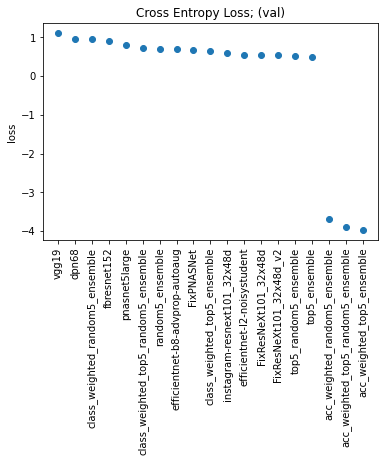

{'class_weighted_random5_ensemble': 1.8633347967555283,
 'vgg19': 1.7994335738758132,
 'dpn68': 1.6298236704937519,
 'fbresnet152': 1.5552721397977132,
 'pnasnet5large': 1.3825247766431887,
 'class_weighted_top5_random5_ensemble': 1.3255855526749045,
 'FixPNASNet': 1.3071399118102736,
 'class_weighted_top5_ensemble': 1.2454025408908724,
 'random5_ensemble': 1.2156569883293473,
 'efficientnet-b8-advprop-autoaug': 1.1125237435229123,
 'instagram-resnext101_32x48d': 1.103926332717826,
 'FixResNeXt101_32x48d': 0.9842859633449642,
 'FixResNeXt101_32x48d_v2': 0.9819011197096806,
 'efficientnet-l2-noisystudent': 0.9222861477904022,
 'top5_random5_ensemble': 0.9132461715057493,
 'top5_ensemble': 0.837606543031335,
 'acc_weighted_random5_ensemble': -2.9885092810188656,
 'acc_weighted_top5_random5_ensemble': -3.375028241763404,
 'acc_weighted_top5_ensemble': -3.512701970028039}

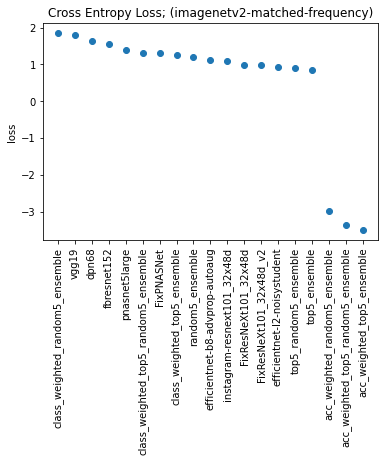

In [119]:
for eval_setting in eval_settings:
    plot_cross_entropy_loss(eval_setting)

### Multiclass ROC 

In [120]:
def plot_multiclass_roc(model, eval_setting='val', topk=1):
    """ https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
    TODO: broken. fix
    """
    
    x = logits[eval_setting][model]
    
    if 'ensemble' not in model: # ensembled logits have already been through softmax
        x = softmax(x, dim=1)
    x[x != x] = 0 # set nan values to zero.
    x = x / torch.sum(x, 1)[:, None] # normalize each image to total probability of 1
    
    y = label_binarize(targets[eval_setting], classes=np.arange(1000))
    n_classes = y.shape[1]
    _, y_score = partition(x, eval_setting)
    _, y_test = partition(y, eval_setting)

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i].numpy())
        roc_auc[i] = auc(fpr[i], tpr[i])
                
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(np.ravel(y_test), np.ravel(y_score))
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes
    print('mean_tpr', mean_tpr)
    print('all_fpr', all_fpr)
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    lw = 2
    plt.figure()
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)
    
    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Some extension of Receiver operating characteristic to multi-class')
    plt.legend(loc="lower right")
    plt.show();

# plot_multiclass_roc('dpn68')

In [78]:
def plot_roc_curve(model):
    """ Plots ROC curve 
    y_pred is the max softmax score for a given image
    y_true is if the image was correctly classified or not
    """
    
    fig, axs = plt.subplots(2, 2, figsize=(10, 10))
    fig.subplots_adjust(top=0.95)
    
    for ax_i, eval_setting in enumerate(eval_settings):
        for ax_j, topk in enumerate([1, 3]):    
            eval_targets_train, eval_targets_test = partition(targets[eval_setting], eval_setting)
            x = logits[eval_setting][model]
            if 'ensemble' not in model: # ensembled logits have already been through softmax
                x = softmax(x, dim=1)
            x[x != x] = 0 # set nan values to zero.
            x = x / torch.sum(x, 1)[:, None] # normalize each image to total probability of 1

            prob, pred = x.topk(topk, 1, True, True)
            pred = pred.t()

            train_pred = []
            for i in range(pred.size(0)):
                train_pred.append(partition(pred[i], eval_setting)[0]) # training pred
            pred = torch.stack(train_pred)
            prob = prob.sum(1) # sum normalized topk probabilities
            correct = pred.eq(eval_targets_train.view(1, -1).expand_as(pred))

            corr = []
            for i in range(correct.size(1)):
                if correct[:,i].sum() > 0: # one of topk classified correctly
                    corr.append(True)
                else:
                    corr.append(False)

            y_true = torch.tensor(corr).float()
            y_prob = prob.flatten()
            y_prob, _ = partition(y_prob, eval_setting)

            fpr, tpr, _ = roc_curve(y_true, y_prob)
            roc_auc = auc(fpr, tpr)
            
            axs[ax_i, ax_j].plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.4f)' % roc_auc)
            axs[ax_i, ax_j].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
            axs[ax_i, ax_j].set_xlim([0.0, 1.0])
            axs[ax_i, ax_j].set_ylim([0.0, 1.05])
            axs[ax_i, ax_j].set_xlabel('False Positive Rate')
            axs[ax_i, ax_j].set_ylabel('True Positive Rate')
            axs[ax_i, ax_j].set_title(f'{eval_setting}, top-{topk}')
            axs[ax_i, ax_j].legend(loc="lower right")

    fig.suptitle(f'ROC Curves: {model}', fontweight='bold')
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    fig.savefig(join(logdir, f'ROC_{model}'))
    plt.show();

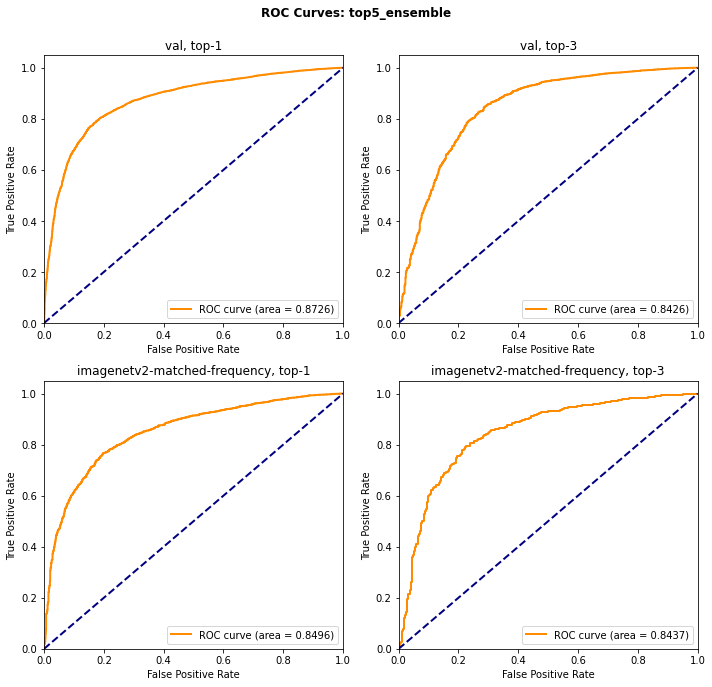

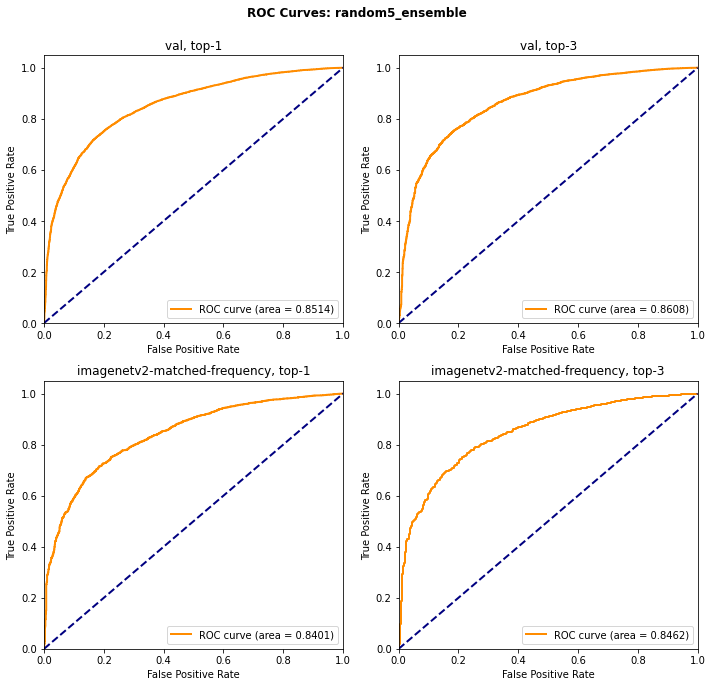

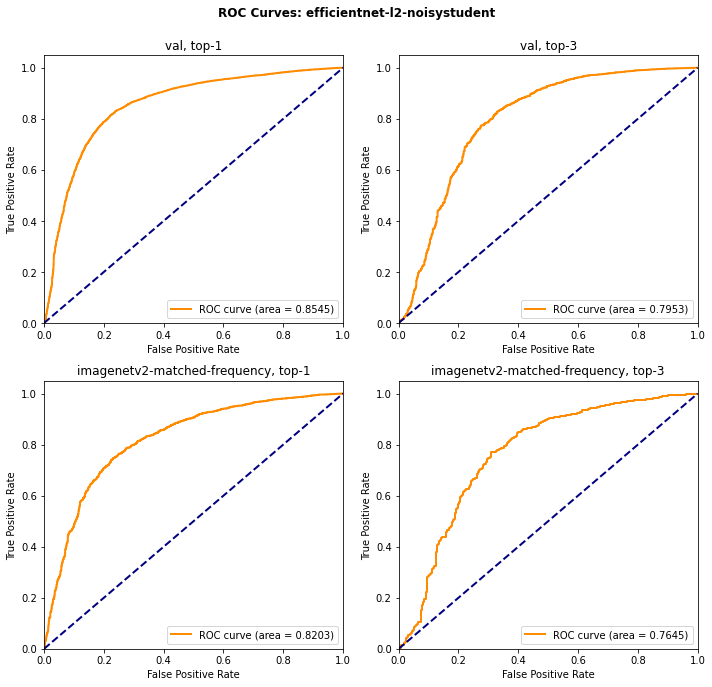

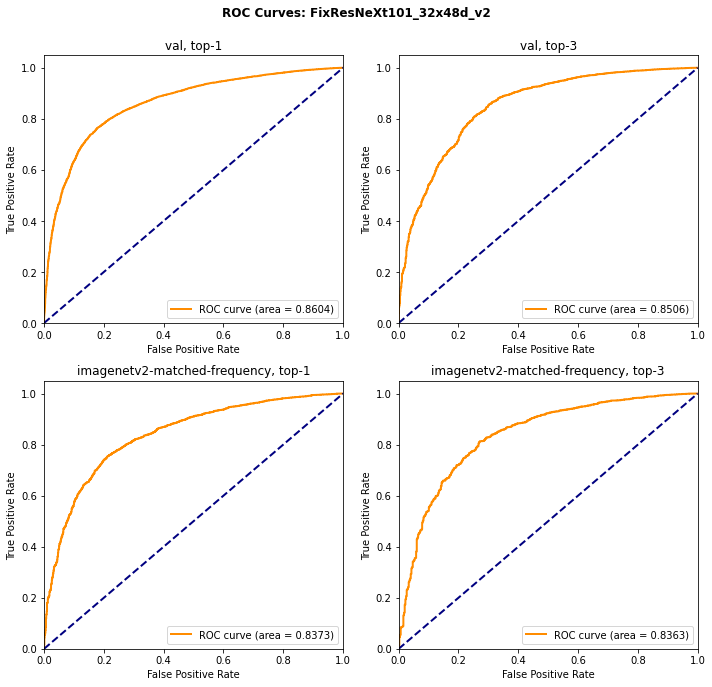

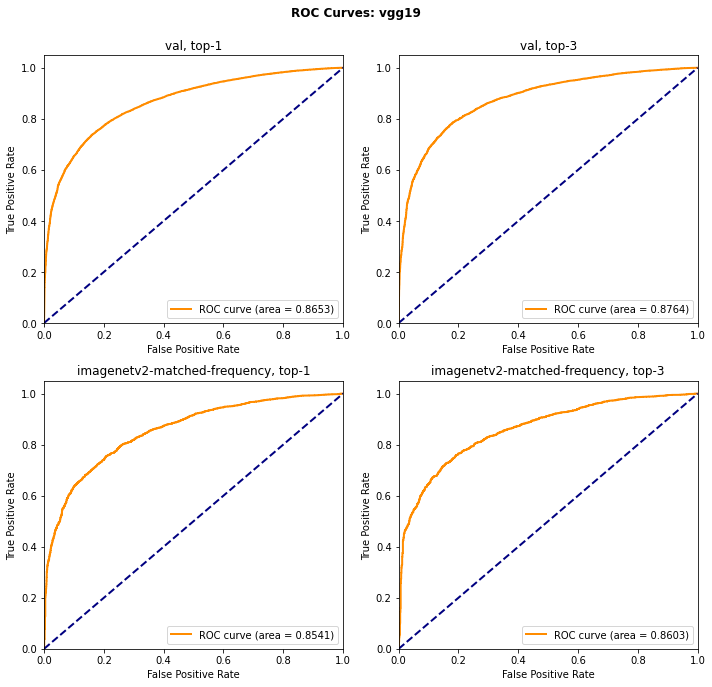

In [79]:
for model in ['top5_ensemble', 'random5_ensemble', 'efficientnet-l2-noisystudent', 'FixResNeXt101_32x48d_v2', 'vgg19']:
    plot_roc_curve(model)